In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
from torch import functional as F

import torchtext
from torchtext.datasets import WikiText2
from torchtext import data

import numpy as np

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
!ls

drive  sample_data  spm.model  spm.vocab  wikitext2_train.txt


In [ ]:
!cp drive/My\ Drive/wikitext2_train.txt wikitext2_train.txt

In [ ]:
VOCAB_SIZE = 16000
BATCH_SIZE = 512
HIDDEN_SIZE = 512
BPTT_LEN = 50
N_EPOCHS = 100

checkpoint = 'drive/My Drive/rnn_lm.pt'

In [ ]:
spm.SentencePieceTrainer.Train('--input=wikitext2_train.txt --model_prefix=spm --vocab_size='+str(VOCAB_SIZE))

True

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load("spm.model")

True

In [ ]:
TEXT = torchtext.data.Field(lower=True, tokenize=sp.EncodeAsPieces)

In [ ]:
train, valid, test = torchtext.datasets.WikiText2.splits(TEXT)

In [ ]:
TEXT.build_vocab(train, max_size=VOCAB_SIZE+10)

In [ ]:
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=BPTT_LEN,
    device=device,
    repeat=False)

In [ ]:
class RnnWithHeadLM(nn.Module):
    def __init__(self, ntoken, ninp,
                 nhid, nlayers,
                 dropout=0.5, tie_weights=True):
        super(RNNModel, self).__init__()
        self.nhid, self.nlayers = nhid, nlayers
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.RNN(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.hidden = None
 
    def forward(self, input, hidden=None):
        hidden = self.hidden if hidden is None else hidden
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        self.hidden = hidden 
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1))
  
    def reset_history(self):
        if self.hidden is None:
            return None
        self.hidden = self.hidden.data

In [ ]:
model = RnnWithHeadLM(VOCAB_SIZE, HIDDEN_SIZE, HIDDEN_SIZE, 1)
model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNNModel(
  (drop): Dropout(p=0.5, inplace=False)
  (encoder): Embedding(16000, 512)
  (rnn): RNN(512, 512, dropout=0.5)
  (decoder): Linear(in_features=512, out_features=16000, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(epoch):
    tr_history = []
    tr_loss = 0
    model.train()
    for batch in train_iter:
      model.reset_history()
      optimizer.zero_grad()

      text, targets = batch.text, batch.target
      prediction = model(text)
      loss = criterion(prediction.view(-1, VOCAB_SIZE), targets.view(-1))
      loss.backward()

      optimizer.step()

      tr_history.append(loss.item())
      tr_loss += loss.item() * prediction.size(0) * prediction.size(1)

    tr_loss /= len(train.examples[0].text)

    val_loss = 0
    model.eval()
    for batch in valid_iter:
        model.reset_history()
        text, targets = batch.text, batch.target
        prediction = model(text)
        loss = criterion(prediction.view(-1, VOCAB_SIZE), targets.view(-1))
        val_loss += loss.item() * prediction.size(0) * prediction.size(1)
    val_loss /= len(valid.examples[0].text)

    return tr_loss, tr_history, val_loss

In [ ]:
checkpoint = None

In [ ]:
if checkpoint is not None:
    check = torch.load(checkpoint)
    model.load_state_dict(check['model'])
    optimizer.load_state_dict(check['optimizer'])
    tr_history = check['tr_history']
    val_history = check['val_history']
    epoch = check['epoch']
else:
    tr_history = []
    val_history = []
    epoch = 0

Epoch: 52, Training Loss: 3.9548, Validation Loss: 3.7005


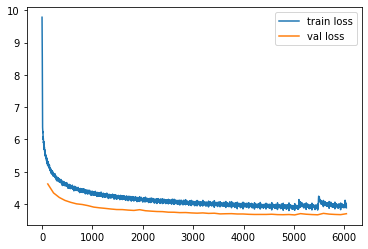

KeyboardInterrupt: ignored

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

for epoch in range(epoch, N_EPOCHS):
    tr_loss, tr_hist, val_loss = train_epoch(epoch)
    tr_history += tr_hist
    val_history += [val_loss] #[val_loss]*len(tr_hist)
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'tr_history': tr_history,
        'val_history': val_history,
        'epoch': epoch+1,
    }, 'drive/My Drive/rnn_lm.pt')

    clear_output()
    print(f'Epoch: {epoch}, Training Loss: {tr_loss:.4f}, Validation Loss: {val_loss:.4f}')
    plt.plot(tr_history, label='train loss')
    plt.plot([(i+1)*len(tr_hist) for i in range(epoch+1)], val_history, label='val loss')
    plt.legend()
    plt.show()

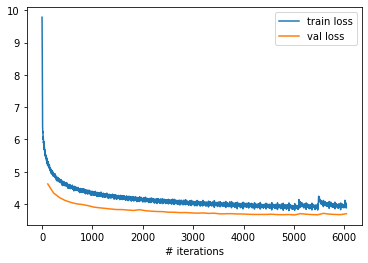

In [ ]:
from matplotlib import pyplot as plt

plt.plot(tr_history, label='train loss')
plt.plot([(i+1)*len(tr_hist) for i in range(len(val_history))], val_history, label='val loss')
plt.xlabel('# iterations')
plt.legend()

## Generation

In [ ]:
context_strs = ["During its first decade , the newly formed Irish Free State was governed by the victors of the civil war . When de Valera achieved power , he took advantage of the <unk> of Westminster and political circumstances to build upon <unk> to greater sovereignty made by the previous government .",
                "Northern Ireland was created as a division of the United Kingdom by the Government of Ireland Act 1920 and until 1972 it was a self @-@ governing jurisdiction within the United Kingdom with its own parliament and prime minister .",
                "The storm originated in an upper @-@ level low pressure system that moved southeastward from the central Great Plains into the Deep South of the United States .",
                "The malignant cell in AML is the myeloblast . In normal <unk> , the myeloblast is an immature precursor of myeloid white blood cells ; a normal myeloblast will gradually mature into a mature white blood cell ."
]

In [ ]:
context_pieces = [sp.EncodeAsPieces(x) for x in context_strs]

In [ ]:
context_ids = [[TEXT.vocab.stoi[s] for s in x] for x in context_pieces]

inps = [torch.LongTensor(x).unsqueeze(1).to(device) for x in context_ids]

In [ ]:
#code is from hugging_face/transformers

def top_k_top_p_sampling(logits, top_k=0, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(nn.functional.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return torch.multinomial(torch.exp(logits), 1)

In [ ]:
def argmax_sampling(logits):
    return top_k_top_p_sampling(logits, top_k=1)

In [ ]:
def temperature_sampling(logits, t=1.0):
    return top_k_top_p_sampling(logits * (1 / t), top_p=1.0)

In [ ]:
def sample_sequence(model, context, sample_method, continuation_length=150):
    continuation_length = context.size(0)
    past = context
    model.hidden = None

    out = model(past.to(device))
    next_token = sample_method(out[-1, :, :])
    gen = next_token
    past = torch.cat([past, next_token], 0)
    for _ in range(continuation_length-1):
        if next_token.item() == TEXT.vocab.stoi['<eos>']:
          break
        out = model(next_token)
        next_token = sample_method(out[-1, :, :])
        past = torch.cat([past, next_token], 0)
        gen = torch.cat([gen, next_token], 0)
    return past, gen

In [ ]:
def continue_strs(inps, sample_method):
    for i, inp in enumerate(inps):
        str_gen = ""
        while len(str_gen.split()) < 20:
            cat, gen = sample_sequence(model, inp, sample_method)
            str_gen = sp.DecodePieces([TEXT.vocab.itos[i] for i in gen[:, 0].tolist()])
        print('Context: ', context_strs[i])
        print('Continuation: ', sp.DecodePieces([TEXT.vocab.itos[i] for i in gen[:, 0].tolist()]))
        print()

## topk

In [ ]:
for k in [3, 8, 14]:
    print(f'\n=== k = {k} ===\n')
    method = lambda x: top_k_top_p_sampling(x, top_k=k)
    continue_strs(inps, method)


=== k = 3 ===

Context:  During its first decade , the newly formed Irish Free State was governed by the victors of the civil war . When de Valera achieved power , he took advantage of the <unk> of Westminster and political circumstances to build upon <unk> to greater sovereignty made by the previous government .
Continuation:  they was a fascist , known as a <unk> and <unk> bin <unk> . thetheless of <unk> <unk> and the latter was appointed for the president of the▁hawaiian .<eos>

Context:  Northern Ireland was created as a division of the United Kingdom by the Government of Ireland Act 1920 and until 1972 it was a self @-@ governing jurisdiction within the United Kingdom with its own parliament and prime minister .
Continuation:  the first times , the <unk> also had a reputation and also known as a <unk> of <unk> , and <unk> the latter of the games .<eos>

Context:  The storm originated in an upper @-@ level low pressure system that moved southeastward from the central Great Plains 

## Nucleus sampling

In [ ]:
for p in [0.3, 0.7, 0.9, 0.96]:
    print(f'\n=== p = {p} ===\n')
    method = lambda x: top_k_top_p_sampling(x, top_p=p)
    continue_strs(inps, method)


=== p = 0.3 ===

Context:  During its first decade , the newly formed Irish Free State was governed by the victors of the civil war . When de Valera achieved power , he took advantage of the <unk> of Westminster and political circumstances to build upon <unk> to greater sovereignty made by the previous government .
Continuation:  the route was moved to the state of the northern , and the▁british submarine corps and <unk> were diverted to protect them to the construction of the battalion , in the end of the territory , but they 're vehe <unk> a new line of the new building , but <unk> of the <

Context:  Northern Ireland was created as a division of the United Kingdom by the Government of Ireland Act 1920 and until 1972 it was a self @-@ governing jurisdiction within the United Kingdom with its own parliament and prime minister .
Continuation:  they of the▁british novelist <unk> , the first <unk> of the▁british government , in the establishment of the royal navy , <unk> , the <unk> , t

## Argmax

In [ ]:
method = argmax_sampling
continue_strs(inps, method)

Context:  During its first decade , the newly formed Irish Free State was governed by the victors of the civil war . When de Valera achieved power , he took advantage of the <unk> of Westminster and political circumstances to build upon <unk> to greater sovereignty made by the previous government .
Continuation:  they were <unk> , and the▁austrian <unk> <unk> <unk> , <unk> ( <unk> <unk> ) , and they <unk> ( <unk> <unk> ) , and <unk> <unk> <unk> ,

Context:  Northern Ireland was created as a division of the United Kingdom by the Government of Ireland Act 1920 and until 1972 it was a self @-@ governing jurisdiction within the United Kingdom with its own parliament and prime minister .
Continuation:  they were not <unk> in the <unk> , whose idol , they were able to win the games . they was released in the▁united states , and the▁united states , they were <

Context:  The storm originated in an upper @-@ level low pressure system that moved southeastward from the central Great Plains into 

## With temperature

In [ ]:
for t in [0.5, 0.7, 0.8]:
    print(f'\n=== t = {t} ===\n')
    method = lambda x: temperature_sampling(x, t=t)
    continue_strs(inps, method)


=== t = 0.5 ===

Context:  During its first decade , the newly formed Irish Free State was governed by the victors of the civil war . When de Valera achieved power , he took advantage of the <unk> of Westminster and political circumstances to build upon <unk> to greater sovereignty made by the previous government .
Continuation:  the same year , the company 's <unk> of the▁soviet union had to attack the rights from the south . the army was taken to the north of the south of▁trotternte and <unk> , and a largely on the west coast of the south . the hurricane centers were built as a result

Context:  Northern Ireland was created as a division of the United Kingdom by the Government of Ireland Act 1920 and until 1972 it was a self @-@ governing jurisdiction within the United Kingdom with its own parliament and prime minister .
Continuation:  then use of the first time was noted in the early election . in the <unk> , <unk> <unk> <unk> of the▁isle <unk> @-@ priest of the <

Context:  The st